In [1]:
import numpy as np

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

import os
import copy
from itertools import cycle, combinations

import sys
sys.path.append('../..')

import backpack

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_translation', 'ego_rotation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [5]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [6]:
def distance_from_center(agent1, agent2):
    '''
    Calculates the distance between the centroids of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between the two agents' centroids
    '''
    return np.linalg.norm(agent1['centroid'] - agent2['centroid'])

In [7]:
def distance_from_edge(agent1, agent2):
    '''
    Calculates the distance between the closest edges of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between two agents' closest edges
    '''
        
    # generate orthogonal axes for each agent
    a1_length_axis = agent1['extent'][1] / 2 * np.asarray([np.cos(agent1['yaw']), np.sin(agent1['yaw'])])
    a1_width_axis  = agent1['extent'][0] / 2 * np.asarray([np.sin(agent1['yaw']), np.cos(agent1['yaw'])])
    a2_length_axis = agent2['extent'][1] / 2 * np.asarray([np.cos(agent2['yaw']), np.sin(agent2['yaw'])])
    a2_width_axis  = agent2['extent'][0] / 2 * np.asarray([np.sin(agent2['yaw']), np.cos(agent2['yaw'])])
        
    # find two opposite corners of rectangles
    a1_corners = np.asarray([agent1['centroid'] + a1_length_axis * a + a1_width_axis * a for a in [-1, 1]])
    a2_corners = np.asarray([agent2['centroid'] + a2_length_axis * a + a2_width_axis * a for a in [-1, 1]])
    
    # convert corners into cartesian intervals
    a1_max = np.maximum(*a1_corners)
    a1_min = np.minimum(*a1_corners)
    a2_max = np.maximum(*a2_corners)
    a2_min = np.minimum(*a2_corners)
    
    # compute minkowski distance for rectangles
    y = np.maximum(0, np.maximum(a1_min - a2_max, a2_min - a1_max))
    
    return np.sum(np.abs(y) ** 2, axis=-1) ** (1/2)

In [8]:
distance_from_center(agents[1], agents[5])

53.94792262705793

In [9]:
distance_from_edge(agents[1], agents[5])

51.33004967277152

In [10]:
# playing around with scene 99
scene_i = 99
scene = scenes[scene_i]
scene

{'frame_index_interval': array([24590, 24838]),
 'host': 'host-a101',
 'start_time': 1571844710505151232,
 'end_time': 1571844735505151232}

In [11]:
clusters = []

fii = scene['frame_index_interval']
for frame in frames[fii[0]: fii[1]]:
    
    c = backpack.Cluster(frame, agents)
    c.normalize_data()
    
    clusters.append(c)

[{20: {22: 4.118168294429779, 23: 30.016083839142468, 25: 36.945434903020896},
  22: {20: 4.118168294429779, 23: 34.98684948682495, 25: 42.184250791030315},
  23: {20: 30.016083839142468, 22: 34.98684948682495, 25: 6.475880361812096},
  25: {20: 36.945434903020896, 22: 42.184250791030315, 23: 6.475880361812096}}]

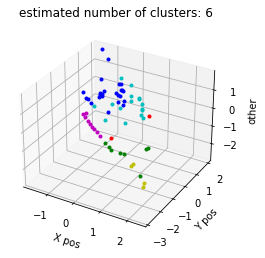

In [12]:
clusters[0].kmeans_cluster(n_clusters=6)
clusters[0].plot()
clusters[0].generate_distance_matrixes()

In [ ]:
# get the agent indices associated with each cluster

cluster_to_indices = [None] * n_clusters_

for i, label in enumerate(labels):
    
    # if we have not created the array at the index yet, do so
    if not cluster_to_indices[label]:
        cluster_to_indices[label] = []
    
    cluster_to_indices[label].append(i)

In [ ]:
# maps a cluster / label index to a distance matrix for the agents in that cluster
distance_matrices = []

# find appropriate indices
scene = scenes[scene_i]
frame = frames[scene['frame_index_interval'][0] + frame_i]
agent_baseline_index = frame['agent_index_interval'][0]

for cluster in cluster_to_indices:
    matrix = {}
    # choose every possibility of two agents in a cluster
    for comb in combinations(cluster, 2):
        agent1_index = agent_baseline_index + comb[0]
        agent2_index = agent_baseline_index + comb[1]
        
        agent1 = agents[agent1_index]
        agent2 = agents[agent2_index]
        
        edge_distance = distance_from_edge(agent1, agent2)
                
        if comb[0] not in matrix:
            matrix[comb[0]] = {}
        if comb[1] not in matrix:
            matrix[comb[1]] = {}
        
        matrix[comb[0]][comb[1]] = matrix[comb[1]][comb[0]] = edge_distance
        
    distance_matrices.append(matrix)

In [ ]:
# this really needs better organization as the data goes on. must be easily attributed to a particular agent
# at a particular timestamp. needs good organization with time

In [ ]:
distance_matrices